In [1]:
import sys
sys.path.append('..')

from tools.siren import *
from tools.table import *

from scipy import interpolate
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 10

In [3]:
table = Table('cprof_mu_train_10000ev.h5')

# Create input data exactly as before
ene_bins = table.normalize(0, table.binning[0])
cos_bins = table.normalize(1, table.binning[1])
trk_bins = table.normalize(2, table.binning[2])
linear_interpolator = interpolate.interp1d(table.binning[0], ene_bins, kind='linear')

cos_trk_mesh = np.array([[x,y] for x in cos_bins for y in trk_bins])
inputs = np.array([[ene_bins[50], x, y] for x in cos_bins for y in trk_bins])

# Load and prepare JAX model
input_shape = inputs.shape
jax_model, jax_params = load_siren_jax('siren_cprof_mu.pkl')

# Convert inputs to JAX array
jax_inputs = jnp.array(inputs)

# Perform inference
model_output, _ = jax_model.apply(jax_params, jax_inputs)

# Convert to numpy and reshape (equivalent to PyTorch reshape)
reco_value = np.array(model_output).reshape(len(cos_bins), len(trk_bins))

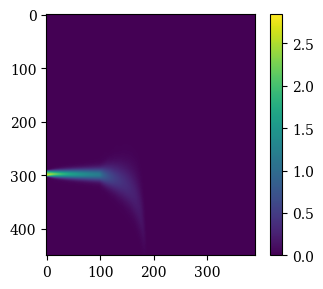

In [4]:
fig, axes = plt.subplots(1,1, figsize=(3.5,3))
fig.patch.set_facecolor('white')
im0 = axes.imshow(reco_value)
fig.colorbar(im0, ax=axes)
fig.tight_layout()
plt.show()

In [5]:
import ROOT
fname_in='mu_530_MeV.root' # this is just an example file for one muon event simulated with GEANT4 with an energy of 530 MeV.
root_file = ROOT.TFile(fname_in)
rebinned_hist = root_file.trg.Rebin2D(30, 30, "rebinned_trg")

nbins_x = rebinned_hist.GetNbinsX()
nbins_y = rebinned_hist.GetNbinsY()

print(f"Number of X bins: {nbins_x}")
print(f"Number of Y bins: {nbins_y}")

x_centers = np.array([rebinned_hist.GetXaxis().GetBinCenter(i) for i in range(1, nbins_x + 1)])
y_centers = np.array([rebinned_hist.GetYaxis().GetBinCenter(i) for i in range(1, nbins_y + 1)])

observed_values = np.zeros((nbins_x, nbins_y))

for i in range(nbins_x):
    for j in range(nbins_y):
        observed_values[i,j] = rebinned_hist.GetBinContent(i+1, j+1)  # Note: ROOT bins start at 1


new_cos_bins = table.normalize(1, x_centers)
new_trk_bins = table.normalize(2, y_centers)

Welcome to JupyROOT 6.28/00
Number of X bins: 83
Number of Y bins: 100


In [6]:
import numpy as np

def compare_normalized_columns_mse(grid1, grid2):
    """
    Compare two 2D distributions by:
    1. Normalizing each column by its integral (sum)
    2. Calculating MSE between normalized columns
    3. Summing all MSE values
    
    Parameters:
    grid1, grid2: 2D numpy arrays of the same shape
    
    Returns:
    float: Sum of MSE values across all columns
    """
    if grid1.shape != grid2.shape:
        raise ValueError("Grids must have the same shape")
    
    # Initialize array for MSE values
    n_cols = grid1.shape[1]
    mse_values = np.zeros(n_cols)
    
    # Process each column
    for i in range(n_cols):
        # Get columns
        col1 = grid1[:, i]
        col2 = grid2[:, i]
        
        # Normalize by sum (integral)
        # Add small epsilon to avoid division by zero
        epsilon = 1e-10
        norm_col1 = col1 / (np.sum(col1) + epsilon)
        norm_col2 = col2 / (np.sum(col2) + epsilon)
        
        # Calculate MSE for this column
        mse_values[i] = np.mean((norm_col1 - norm_col2) ** 2)
    
    return np.sum(mse_values)

In [7]:
energies = np.linspace(450,650,80)

def compare_batch_inference_jax(ene_bins, new_cos_bins, new_trk_bins, x_centers, y_centers, observed_values):
    results = []
    
    # Load JAX model once - reuse for all inferences
    # Create a sample input to get the shape
    sample_input = np.array([[ene_bins[0], new_cos_bins[0], new_trk_bins[0]]])
    jax_model, jax_params = load_siren_jax('siren_cprof_mu.pkl')
    
    # Process each energy bin
    for energy in energies:
        # Create input array for this energy level
        new_inputs = np.array([[linear_interpolator(energy), x,y] for x in new_cos_bins for y in new_trk_bins])
        
        # Convert to JAX array
        jax_inputs = jnp.array(new_inputs)
        
        # Perform inference
        model_output, _ = jax_model.apply(jax_params, jax_inputs)
        
        # Reshape the output to match the desired dimensions
        new_reco_value = np.array(model_output).reshape(len(x_centers), len(y_centers))
        
        # Compare with observed values
        result = compare_normalized_columns_mse(new_reco_value, observed_values)
        results.append(result)
    
    return np.array(results)

# Use the function
results = compare_batch_inference_jax(
    ene_bins=ene_bins,
    new_cos_bins=new_cos_bins,
    new_trk_bins=new_trk_bins,
    x_centers=x_centers,
    y_centers=y_centers,
    observed_values=observed_values
)

reco:  523.4177215189874
0.014329568517225031


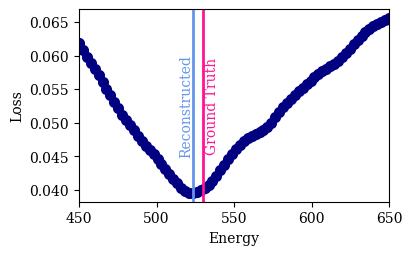

In [8]:
reco = energies[np.argmin(results)]
print('reco: ', reco)
plt.figure(figsize=(4, 2.5))
plt.scatter(energies, results, color='navy', lw=2)
plt.plot(energies, results, color='navy', lw=2)
plt.gca().set_xlim(min(energies), max(energies))

c1 = 'cornflowerblue'
c2 = 'deeppink'

print((plt.ylim()[1]-plt.ylim()[0])/2)
plt.axvline(530, color=c2, lw=2)
plt.text(540, plt.ylim()[0]+(plt.ylim()[1]-plt.ylim()[0])/2, 'Ground Truth', rotation=90, 
         va='center', ha='right', color=c2)

plt.axvline(reco, color=c1, lw=2)
plt.text(reco,  plt.ylim()[0]+(plt.ylim()[1]-plt.ylim()[0])/2, 'Reconstructed', rotation=90,
         va='center', ha='right', color=c1)

plt.gca().set_xlabel('Energy')
_  = plt.gca().set_ylabel('Loss')

In [9]:
import jax
import jax.numpy as jnp
from jax import grad, jit, value_and_grad
import optax

def compare_normalized_columns_mse_jax(grid1, grid2):
    """JAX-compatible version of compare_normalized_columns_mse"""
    # Make sure shapes match
    assert grid1.shape == grid2.shape, f"Shape mismatch: {grid1.shape} vs {grid2.shape}"
    
    epsilon = 1e-10
    
    col_sums1 = jnp.sum(grid1, axis=0) + epsilon
    col_sums2 = jnp.sum(grid2, axis=0) + epsilon
    
    norm_grid1 = grid1 / col_sums1[None, :]
    norm_grid2 = grid2 / col_sums2[None, :]
    
    mse_values = jnp.mean((norm_grid1 - norm_grid2) ** 2, axis=0)
    return jnp.sum(mse_values)

def create_energy_loss_fn(jax_model, jax_params, new_cos_bins, new_trk_bins, 
                         x_centers, y_centers, observed_values,
                         slope, intercept):
    """Create loss function using linear interpolation parameters"""
    
    # Convert to JAX arrays and prepare meshgrid once
    new_cos_bins = jnp.array(new_cos_bins)
    new_trk_bins = jnp.array(new_trk_bins)
    observed_values = jnp.array(observed_values)
    
    # Create meshgrid for coordinates - note the indexing='ij' for correct ordering
    cos_mesh, trk_mesh = jnp.meshgrid(new_cos_bins, new_trk_bins, indexing='ij')
    coord_grid = jnp.stack([cos_mesh.ravel(), trk_mesh.ravel()], axis=-1)
    
    @jit
    def loss_fn(energy):
        # Linear interpolation using slope and intercept
        normalized_energy = slope * energy + intercept
        
        # Create input array using broadcasting
        energy_column = jnp.full((coord_grid.shape[0], 1), normalized_energy)
        inputs = jnp.concatenate([energy_column, coord_grid], axis=1)
        
        # Get model prediction
        model_output, _ = jax_model.apply(jax_params, inputs)
        # Reshape to match observed_values shape
        predicted_grid = jnp.reshape(model_output, (len(new_cos_bins), len(new_trk_bins)))
        
        # Compare with observed values using JAX version
        return compare_normalized_columns_mse_jax(predicted_grid, observed_values)
    
    return loss_fn

def optimize_energy(initial_energy=500.0):
    """Main optimization function"""
    # Load model
    sample_input = jnp.array([[0.0, new_cos_bins[0], new_trk_bins[0]]])
    jax_model, jax_params = load_siren_jax('siren_cprof_mu.pkl')
    
    # Get interpolation parameters for the current energy region
    idx = np.searchsorted(table.binning[0], initial_energy)
    x1, x2 = table.binning[0][idx-1:idx+1]
    y1 = table.normalize(0, x1)
    y2 = table.normalize(0, x2)
    slope = (y2 - y1) / (x2 - x1)
    intercept = y1 - slope * x1
    
    print(f"Interpolation params: slope={slope:.6f}, intercept={intercept:.6f}")
    print(f"Input shapes: cos_bins={new_cos_bins.shape}, trk_bins={new_trk_bins.shape}")
    print(f"Observed values shape: {observed_values.shape}")
    
    # Create loss function
    loss_fn = create_energy_loss_fn(
        jax_model=jax_model,
        jax_params=jax_params,
        new_cos_bins=new_cos_bins,
        new_trk_bins=new_trk_bins,
        x_centers=x_centers,
        y_centers=y_centers,
        observed_values=observed_values,
        slope=slope,
        intercept=intercept
    )
    
    # Create optimizer
    optimizer = optax.adam(learning_rate=0.5)
    opt_state = optimizer.init(jnp.array(initial_energy))
    
    # Optimization loop
    energy = jnp.array(initial_energy)
    loss_and_grad_fn = value_and_grad(loss_fn)
    
    losses = []
    energies = []
    
    for step in range(300):
        loss, grads = loss_and_grad_fn(energy)
        updates, opt_state = optimizer.update(grads, opt_state)
        energy = optax.apply_updates(energy, updates)
        
        losses.append(float(loss))
        energies.append(float(energy))

        if step>1:
            if abs(losses[-1]-losses[-2])<1e-7:
                break        
        
        if step % 10 == 0:
            print(f"Step {step}: Energy = {float(energy):.2f}, Loss = {float(loss):.6f}")
    
    return float(energy), losses, energies

In [10]:
optimal_energy, losses, energies = optimize_energy(initial_energy=600.0)
print(f"Optimal energy found: {optimal_energy:.2f}")

Interpolation params: slope=0.002105, intercept=-1.105263
Input shapes: cos_bins=(83,), trk_bins=(100,)
Observed values shape: (83, 100)
Step 0: Energy = 599.50, Loss = 0.056366
Step 10: Energy = 594.50, Loss = 0.055376
Step 20: Energy = 589.46, Loss = 0.054320
Step 30: Energy = 584.26, Loss = 0.053123
Step 40: Energy = 578.78, Loss = 0.051633
Step 50: Energy = 572.96, Loss = 0.049880
Step 60: Energy = 567.75, Loss = 0.048793
Step 70: Energy = 564.00, Loss = 0.048364
Step 80: Energy = 561.01, Loss = 0.048025
Step 90: Energy = 557.83, Loss = 0.047561
Step 100: Energy = 553.89, Loss = 0.046815
Step 110: Energy = 548.90, Loss = 0.045573
Step 120: Energy = 542.81, Loss = 0.043696
Step 130: Energy = 536.17, Loss = 0.041573
Step 140: Energy = 530.28, Loss = 0.040233
Step 150: Energy = 526.08, Loss = 0.039696
Step 160: Energy = 523.48, Loss = 0.039540
Optimal energy found: 522.62


In [11]:
# # First, let's compute the grid search values
grid_energies = np.linspace(450, 650, 200)  # More points for smoother landscape
grid_results = []

for energy in grid_energies:
    new_inputs = np.array([[linear_interpolator(energy), x, y] 
                          for x in new_cos_bins 
                          for y in new_trk_bins])
    jax_inputs = jnp.array(new_inputs)
    model_output, _ = jax_model.apply(jax_params, jax_inputs)
    predicted_grid = np.reshape(model_output, (len(new_cos_bins), len(new_trk_bins)))
    result = compare_normalized_columns_mse(predicted_grid, observed_values)
    grid_results.append(result)

# # Now run the optimization and visualization
optimal_energy, losses, energies = optimize_energy(initial_energy=600.0)

Interpolation params: slope=0.002105, intercept=-1.105263
Input shapes: cos_bins=(83,), trk_bins=(100,)
Observed values shape: (83, 100)
Step 0: Energy = 599.50, Loss = 0.056366
Step 10: Energy = 594.50, Loss = 0.055376
Step 20: Energy = 589.46, Loss = 0.054320
Step 30: Energy = 584.26, Loss = 0.053123
Step 40: Energy = 578.78, Loss = 0.051633
Step 50: Energy = 572.96, Loss = 0.049880
Step 60: Energy = 567.75, Loss = 0.048793
Step 70: Energy = 564.00, Loss = 0.048364
Step 80: Energy = 561.01, Loss = 0.048025
Step 90: Energy = 557.83, Loss = 0.047561
Step 100: Energy = 553.89, Loss = 0.046815
Step 110: Energy = 548.90, Loss = 0.045573
Step 120: Energy = 542.81, Loss = 0.043696
Step 130: Energy = 536.17, Loss = 0.041573
Step 140: Energy = 530.28, Loss = 0.040233
Step 150: Energy = 526.08, Loss = 0.039696
Step 160: Energy = 523.48, Loss = 0.039540


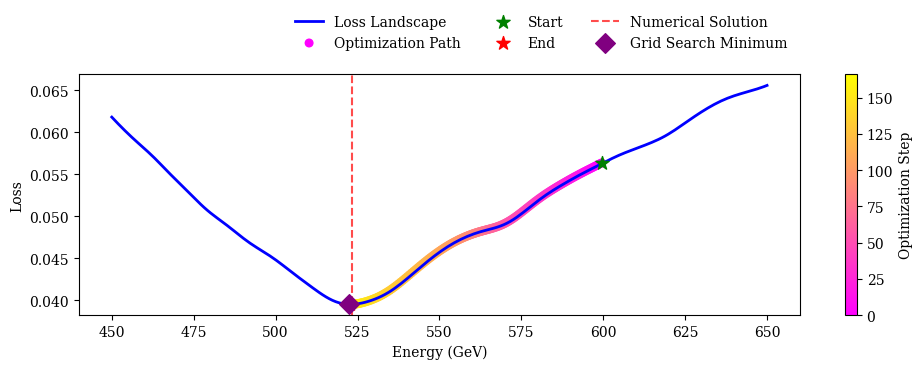

In [12]:
def visualize_optimization_landscape(energies, losses, optimization_energies, optimization_losses):
    """
    Create a visualization showing the loss landscape and optimization trajectory
    
    Args:
        energies: Array of energy points from grid search
        losses: Array of loss values from grid search
        optimization_energies: List of energies visited during optimization
        optimization_losses: List of loss values during optimization
    """
    plt.figure(figsize=(10, 4))
    
    # Create main plot and twin axis for trajectory markers
    ax1 = plt.gca()
    
    # Plot loss landscape
    ax1.plot(energies, losses, 'b-', label='Loss Landscape', linewidth=2, alpha=1)
    ax1.set_xlabel('Energy (GeV)')
    ax1.set_ylabel('Loss')
    
    # Plot optimization trajectory
    colors = plt.cm.viridis(np.linspace(0, 1, len(optimization_energies)))
    scatter = ax1.scatter(optimization_energies, optimization_losses, 
                         c=range(len(optimization_energies)), 
                         cmap='spring', alpha=1, s=30,
                         label='Optimization Path')
    
    # Add colorbar for iteration number
    cbar = plt.colorbar(scatter)
    cbar.set_label('Optimization Step')
    
    # Mark start and end points
    ax1.scatter([optimization_energies[0]], [optimization_losses[0]], 
                color='green', s=100, marker='*', 
                label='Start', zorder=5)
    ax1.scatter([optimization_energies[-1]], [optimization_losses[-1]], 
                color='red', s=100, marker='*', 
                label='End', zorder=5)
    
    # Add ground truth line
    ax1.axvline(reco, color='red', linestyle='--', label='Numerical Solution', alpha=0.7)
    
    # Mark minimum of grid search
    min_idx = np.argmin(losses)
    ax1.scatter([energies[min_idx]], [losses[min_idx]], 
                color='purple', s=100, marker='D', 
                label='Grid Search Minimum', zorder=5)
    
    #plt.title('Loss Landscape and Optimization Trajectory')
    #plt.grid(True, alpha=0.3)
    plt.legend(loc='upper right', frameon=False, ncol=3, bbox_to_anchor=(1, 1.3))
    
    # # Add step annotations for first few iterations
    # for i in range(0, min(10, len(optimization_energies)), 2):
    #     ax1.annotate(f'Step {i}', 
    #                 (optimization_energies[i], optimization_losses[i]),
    #                 xytext=(10, 10), textcoords='offset points',
    #                 fontsize=8, alpha=0.7)
    
    plt.tight_layout()
    plt.show()


visualize_optimization_landscape(grid_energies, grid_results, energies, losses)